### Here we will visualize the outputs to a Migdal skim

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from migYOLO.utils.readYAML import read_config_file
from migYOLO.pipeline.pipeline import downsample

In [2]:
'''Open up globalConf'''
conf = read_config_file('globalConf.yaml')

In [3]:
conf

{'yoloConf': {'model': '../models/base.pt',
  'calibration_file': '../data/calibration_files/test_calibration.npy',
  'vignetting_map': '../data/calibration_files/test_map.pkl',
  'downsample_path': '../data/downsampled_images',
  'outpath': 'output',
  'save_pixels': False,
  'remove_downsample': True,
  'png_threshold': 1.4,
  'png_saturation': 4,
  'migdal_cut': 'NR_energy > 60 & centroid_dist < 6'},
 'downsample': {'dark_file': '../data/dark/sample_master_dark.npy',
  'data_dir': '../data/raw_images',
  'outpath': '../data/downsampled_images'}}

In [4]:
'''Load outputs'''
yolodir = conf['yoloConf']['outpath']+'/base/without_pixel_hits/'
migdal_candidate_dir = yolodir + 'migdal_candidates/'

In [5]:
os.listdir(yolodir)

['Images_batch_2.feather',
 'migdal_candidates',
 'Images_batch_1.feather',
 'Images_batch_4.feather',
 'Images_batch_5.feather',
 'Images_batch_3.feather']

In [6]:
import re
'''Convention is a number comes after an underscore in our filenames so we'll extract this'''
def find_number_in_filename(filename):
    match = re.search(r'_(\d+)', filename)
    if match:
        return match.group(1)
    return None

def load_data(migdal_candidates = False):
    if not migdal_candidates:
        path = yolodir
    else:
        path = migdal_candidate_dir
    dfs = []
    for fi in sorted(os.listdir(path)):
        if '.feather' in fi:
            df = pd.read_feather(path+fi)
            df['fnum'] = find_number_in_filename(fi)
            dfs.append(df)
    df = pd.concat(dfs)
    df.index = [i for i in range(0,len(df))]
    return df

In [7]:
df = load_data(migdal_candidates = False)

In [8]:
migs = load_data(migdal_candidates = True)

In [9]:
migs

,original_index,prediction,prob,colmin,colmax,rowmin,rowmax,energy,true_length,centroidx,...,centroid_dist,coinc_flag,NR_idx,ER_idx,ER_length,NR_length,ER_energy,NR_energy,Ediff,fnum
0,55,"[2.0, 0.0]","[0.8821142315864563, 0.8126000165939331]","[381, 415]","[422, 439]","[57, 56]","[93, 74]","[223.65317282850046, 7.762700735403671]","[6.915681179076163, 3.756393120238375]","[401.5, 427.0]",...,4.279796,True,0,1,3.756393,6.915681,7.762701,223.653173,215.890472,1
1,71,"[2.0, 0.0]","[0.8689148426055908, 0.8099227547645569]","[350, 335]","[387, 355]","[210, 219]","[249, 237]","[230.9716602410759, 4.604029325338108]","[7.745996416909371, 3.5378387628345953]","[368.5, 345.0]",...,3.679347,True,0,1,3.537839,7.745996,4.604029,230.971660,226.367631,2
2,154,"[2.0, 0.0]","[0.8799880743026733, 0.8430924415588379]","[241, 269]","[274, 291]","[59, 53]","[91, 75]","[83.40896520244137, 4.5231531271743695]","[6.19961614246253, 3.5944933104713472]","[257.5, 280.0]",...,3.913275,True,0,1,3.594493,6.199616,4.523153,83.408965,78.885812,2
3,168,"[2.0, 0.0]","[0.8495877981185913, 0.5239024758338928]","[58, 77]","[109, 91]","[223, 220]","[255, 231]","[222.76785328746388, 5.900229107317312]","[7.934964341967619, 2.1311707037918137]","[83.5, 84.0]",...,2.110821,True,0,1,2.131171,7.934964,5.900229,222.767853,216.867624,2
4,170,"[2.0, 0.0]","[0.8771983981132507, 0.847265362739563]","[334, 308]","[367, 332]","[28, 43]","[68, 64]","[84.7853066880907, 4.245801961081776]","[6.679113948958979, 4.01082224061283]","[350.5, 320.0]",...,4.842490,True,0,1,4.010822,6.679114,4.245802,84.785307,80.539505,2
5,134,"[2.0, 0.0]","[0.7870771884918213, 0.33018743991851807]","[389, 404]","[430, 425]","[5, 21]","[26, 31]","[72.08702698896366, 8.990865310268477]","[6.446269622894576, 3.1425335863927906]","[409.5, 414.5]",...,1.817141,True,0,1,3.142534,6.446270,8.990865,72.087027,63.096162,2
6,143,"[2.0, 0.0]","[0.8651227951049805, 0.5303476452827454]","[430, 469]","[501, 495]","[91, 125]","[127, 153]","[358.1276371634304, 9.838806355519159]","[11.283272232057628, 5.320794381579117]","[465.5, 482.0]",...,5.349709,True,0,1,5.320794,11.283272,9.838806,358.127637,348.288831,2
7,143,"[2.0, 0.0]","[0.8651227951049805, 0.3605068624019623]","[430, 469]","[501, 502]","[91, 122]","[127, 153]","[358.1276371634304, 13.57083080888928]","[11.283272232057628, 6.474137566315834]","[465.5, 485.5]",...,5.440216,True,0,1,6.474138,11.283272,13.570831,358.127637,344.556806,2
8,175,"[2.0, 0.0]","[0.8799222111701965, 0.6668704152107239]","[130, 50]","[180, 81]","[226, 244]","[270, 275]","[259.8442191025719, 8.719608653693715]","[9.693867810139096, 6.274739285636333]","[155.0, 65.5]",...,4.533943,True,0,1,6.274739,9.693868,8.719609,259.844219,251.124610,2
9,17,"[2.0, 0.0]","[0.8649650812149048, 0.8312885165214539]","[255, 225]","[284, 245]","[113, 112]","[146, 133]","[71.22215004332087, 5.644817235792664]","[5.744580359317104, 4.215656947092201]","[269.5, 235.0]",...,5.500466,True,0,1,4.215657,5.744580,5.644817,71.222150,65.577333,4


### Lets plot some images

In [10]:
imagepath = conf['downsample']['data_dir']

In [11]:
imagepath

'../data/raw_images'

In [12]:
migs.columns

Index(['original_index', 'prediction', 'prob', 'colmin', 'colmax', 'rowmin',
       'rowmax', 'energy', 'true_length', 'centroidx', 'centroidy', 'IoU',
       'centroid_dist', 'coinc_flag', 'NR_idx', 'ER_idx', 'ER_length',
       'NR_length', 'ER_energy', 'NR_energy', 'Ediff', 'fnum'],
      dtype='object')

In [13]:
#Open up a single frame from an MTIFF
import tifffile
def quick_read(MTIFF_file,frame_index): 
    with tifffile.TiffFile(MTIFF_file) as tif: 
        image = tif.asarray(key=frame_index)
    return image

In [34]:
def plot_event(df,i,process_image):
    tmp = df.iloc[i]
    imfile_basename = 'Images_batch_'
    imname = imagepath+'/'+imfile_basename+str(tmp['fnum'])+'.MTIFF'
    im = quick_read(imname,tmp['original_index'])
    if process_image:
        a = downsample(im)
        im = a.processedImages
    im[im<0] = 0
    plt.imshow(np.log10(im+1),cmap='jet',vmin = 1.4,vmax=4)
    colors = {0:'pink',1:'cyan',2:'red',3:'yellow',4:'goldenrod',5:'white',6:'green',7:'darkgreen',8:'white'}
    for cmin,cmax,rmin,rmax,pred in zip(tmp['colmin'],tmp['colmax'],tmp['rowmin'],tmp['rowmax'],tmp['prediction']):
        plt.hlines(rmin,cmin,cmax,color = colors[pred],lw=2)
        plt.hlines(rmax,cmin,cmax,color = colors[pred],lw=2)
        plt.vlines(cmin,rmin,rmax,color = colors[pred],lw=2)
        plt.vlines(cmax,rmin,rmax,color = colors[pred],lw=2)
    xmin = tmp['colmin'].min()
    xmax = tmp['colmax'].max()
    ymin = tmp['rowmin'].min()
    ymax = tmp['rowmax'].max()
    plt.xlim(xmin-5,xmax+5)
    plt.ylim(ymin-5,ymax+5)

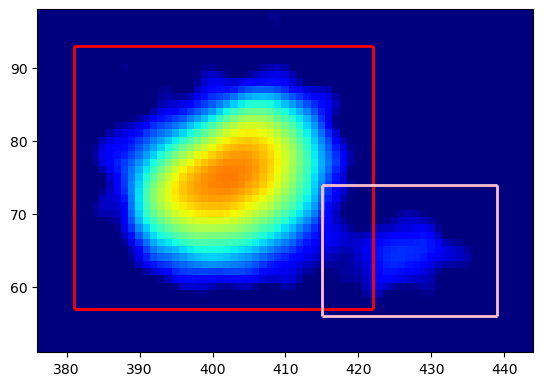

In [55]:
plot_event(migs,0,process_image = True)